# Setup

In [1]:
!pip install -q --upgrade transformers diffusers ftfy accelerate datasets open-clip-torch

In [2]:
!pip install -q torch transformers torchvision

In [3]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

In [4]:
device = (
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)

# DDPM

### Visualization of Training Loss

README.md:   0%|          | 0.00/609 [00:00<?, ?B/s]

Repo card metadata block was not found. Setting CardData to empty.


dataset_infos.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/237M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Previewing batch:


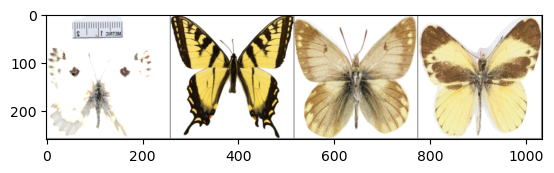

In [5]:
import torchvision
from torchvision import transforms
from datasets import load_dataset

# @markdown load and prepare a dataset:
# Not on Colab? Comments with #@ enable UI tweaks like headings or user inputs
# but can safely be ignored if you're working on a different platform.

dataset_name = "huggan/smithsonian_butterflies_subset"  # @param
dataset = load_dataset(dataset_name, split="train")
image_size = 256  # @param
batch_size = 4  # @param
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

print("Previewing batch:")
batch = next(iter(train_dataloader))
grid = torchvision.utils.make_grid(batch["images"], nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

model_index.json:   0%|          | 0.00/180 [00:00<?, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/256 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/455M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/jovyan/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/jovyan/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/250 [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)


Epoch 0 average loss: 0.015359285217593424


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1 average loss: 0.01449946547159925


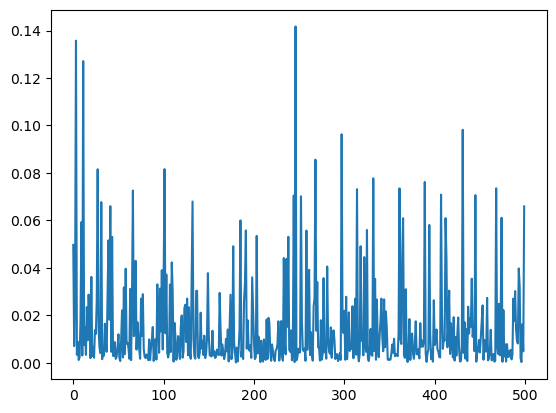

In [6]:
from diffusers import DDPMPipeline
import torch.nn.functional as F

image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device);

num_epochs = 2  # @param
lr = 1e-5  # 2param
grad_accumulation_steps = 2  # @param

optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=lr)

losses = []

for epoch in range(num_epochs):
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0,
            image_pipe.scheduler.num_train_timesteps,
            (bs,),
            device=clean_images.device,
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_images = image_pipe.scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction for the noise
        noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

        # Compare the prediction with the actual noise:
        loss = F.mse_loss(
            noise_pred, noise
        )  # NB - trying to predict noise (eps) not (noisy_ims-clean_ims) or just (clean_ims)

        # Store for later plotting
        losses.append(loss.item())

        # Update the model parameters with the optimizer based on this loss
        loss.backward(loss)

        # Gradient accumulation:
        if (step + 1) % grad_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

    print(
        f"Epoch {epoch} average loss: {sum(losses[-len(train_dataloader):])/len(train_dataloader)}"
    )

# Plot the loss curve:
plt.plot(losses)

  0%|          | 0/1000 [00:00<?, ?it/s]

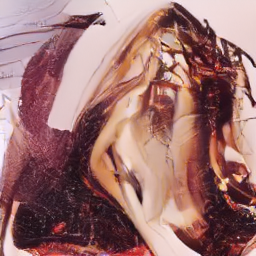

In [11]:
images = image_pipe().images
images[0]

### DDPM vs DDIM

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/jovyan/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/jovyan/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


  0%|          | 0/1000 [00:00<?, ?it/s]

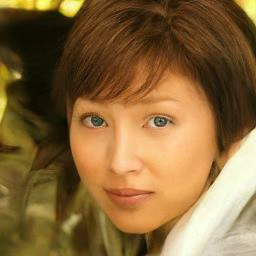

In [33]:
image_pipe = DDPMPipeline.from_pretrained("google/ddpm-celebahq-256")
image_pipe.to(device)

images = image_pipe().images
images[0]

In [13]:
from diffusers import DDIMScheduler, DDPMPipeline
import torchvision

In [38]:
# Load the pretrained pipeline
# pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"

# pipeline_name = "google/ddpm-cifar10-32"
pipeline_name = "google/ddpm-celebahq-256"
# pipeline_name = "google/ddpm-celebahq-1024

image_pipe = DDPMPipeline.from_pretrained(pipeline_name).to(device)

# Sample some images with a DDIM Scheduler over 50 steps
scheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=50)

# Random starting point (batch of 8 images)
x = torch.randn(8, 3, 256, 256).to(device)

# Minimal sampling loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/jovyan/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d: Error no file named diffusion_pytorch_model.safetensors found in directory /home/jovyan/.cache/huggingface/hub/models--google--ddpm-celebahq-256/snapshots/cd5c944777ea2668051904ead6cc120739b86c4d.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


0it [00:00, ?it/s]

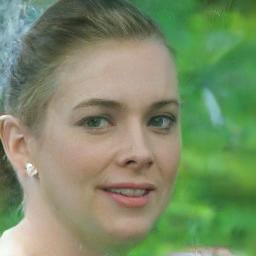

In [15]:
# View the results
# print(x[0].shape)
# grid = torchvision.utils.make_grid(x[:4], nrow=4)
# plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5)
image = (x / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[3]

In [ ]:
scheduler.timesteps

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])

### A look into DDIM text-to-image Pipeline

Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

An error occurred while trying to fetch /home/jovyan/.cache/huggingface/hub/models--johnowhitaker--sd-class-wikiart-from-bedrooms/snapshots/85960f1e0e9d3c1eb2d8c5317a35eb5947e32e70: Error no file named diffusion_pytorch_model.safetensors found in directory /home/jovyan/.cache/huggingface/hub/models--johnowhitaker--sd-class-wikiart-from-bedrooms/snapshots/85960f1e0e9d3c1eb2d8c5317a35eb5947e32e70.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


0it [00:00, ?it/s]

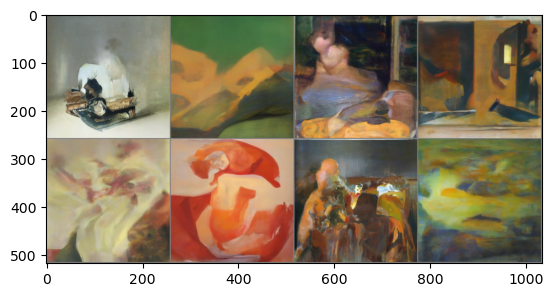

In [42]:
# Load the pretrained pipeline
pipeline_name = "johnowhitaker/sd-class-wikiart-from-bedrooms"
image_pipe = DDPMPipeline.from_pretrained(pipeline_name).to(device)

# Sample some images with a DDIM Scheduler over 40 steps
scheduler = DDIMScheduler.from_pretrained(pipeline_name)
scheduler.set_timesteps(num_inference_steps=40)

# Random starting point (batch of 8 images)
x = torch.randn(8, 3, 256, 256).to(device)

# Minimal sampling loop
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample

# View the results
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);

In [39]:
# @markdown load a CLIP model and define the loss function
import open_clip

clip_model, _, preprocess = open_clip.create_model_and_transforms(
    "ViT-B-32", pretrained="openai"
)
clip_model.to(device)

# Transforms to resize and augment an image + normalize to match CLIP's training data
tfms = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandomResizedCrop(224),  # Random CROP each time
        torchvision.transforms.RandomAffine(
            5
        ),  # One possible random augmentation: skews the image
        torchvision.transforms.RandomHorizontalFlip(),  # You can add additional augmentations if you like
        torchvision.transforms.Normalize(
            mean=(0.48145466, 0.4578275, 0.40821073),
            std=(0.26862954, 0.26130258, 0.27577711),
        ),
    ]
)

# And define a loss function that takes an image, embeds it and compares with
# the text features of the prompt
def clip_loss(image, text_features):
    image_features = clip_model.encode_image(
        tfms(image)
    )  # Note: applies the above transforms
    input_normed = torch.nn.functional.normalize(image_features.unsqueeze(1), dim=2)
    embed_normed = torch.nn.functional.normalize(text_features.unsqueeze(0), dim=2)
    dists = (
        input_normed.sub(embed_normed).norm(dim=2).div(2).arcsin().pow(2).mul(2)
    )  # Squared Great Circle Distance
    return dists.mean()

In [40]:
scheduler.set_timesteps(num_inference_steps=50)
print(scheduler.timesteps)
image_pipe.scheduler = scheduler

tensor([980, 960, 940, 920, 900, 880, 860, 840, 820, 800, 780, 760, 740, 720,
        700, 680, 660, 640, 620, 600, 580, 560, 540, 520, 500, 480, 460, 440,
        420, 400, 380, 360, 340, 320, 300, 280, 260, 240, 220, 200, 180, 160,
        140, 120, 100,  80,  60,  40,  20,   0])


/tmp/ipykernel_77562/1384686437.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():


0it [00:00, ?it/s]

Step: 0 , Guidance loss: 0.0
Step: 25 , Guidance loss: 0.0
Step: 50 , Guidance loss: 0.0
Step: 75 , Guidance loss: 0.0
Step: 100 , Guidance loss: 0.0
Step: 125 , Guidance loss: 0.0
Step: 150 , Guidance loss: 0.0
Step: 175 , Guidance loss: 0.0


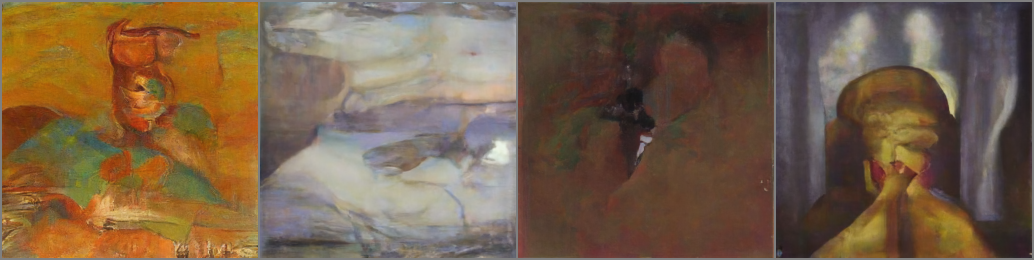

In [47]:
# @markdown applying guidance using CLIP
import numpy as np

prompt = "Red Rose (still life), red flower painting"  # @param

# Explore changing this
guidance_scale = 0  # @param
n_cuts = 4  # @param

# More steps -> more time for the guidance to have an effect
scheduler.set_timesteps(200)

# We embed a prompt with CLIP as our target
text = open_clip.tokenize([prompt]).to(device)
with torch.no_grad(), torch.cuda.amp.autocast():
    text_features = clip_model.encode_text(text)


x = torch.randn(4, 3, 256, 256).to(
    device
)  # RAM usage is high, you may want only 1 image at a time

for i, t in tqdm(enumerate(scheduler.timesteps)):

    model_input = scheduler.scale_model_input(x, t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    cond_grad = 0

    for cut in range(n_cuts):

        # Set requires grad on x
        x = x.detach().requires_grad_()

        # Get the predicted x0:
        x0 = scheduler.step(noise_pred, t, x).pred_original_sample

        # Calculate loss
        loss = clip_loss(x0, text_features) * guidance_scale

        # Get gradient (scale by n_cuts since we want the average)
        cond_grad -= torch.autograd.grad(loss, x)[0] / n_cuts

    if i % 25 == 0:
        print("Step:", i, ", Guidance loss:", loss.item())

    # Modify x based on this gradient
    alpha_bar = scheduler.alphas_cumprod[i]
    x = (
        x.detach() + cond_grad * alpha_bar.sqrt()
    )  # Note the additional scaling factor here!

    # Now step with scheduler
    x = scheduler.step(noise_pred, t, x).prev_sample


grid = torchvision.utils.make_grid(x.detach(), nrow=4)
im = grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5
Image.fromarray(np.array(im * 255).astype(np.uint8))

# Stable Diffusion

### Available model on Hugging Face

In [29]:
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", variant="fp16", torch_dtype=torch.float16, use_auth_token=True).to("cuda")
image = pipe("An astronaught scuba diving").images[0]

Keyword arguments {'use_auth_token': True} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

### A look into the diffusion loop

In [30]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device)

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

/tmp/ipykernel_77562/3173911458.py:31: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8)


  0%|          | 0/100 [00:00<?, ?it/s]

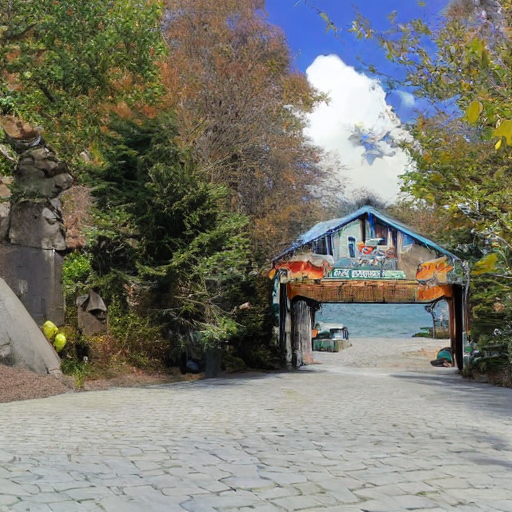

In [31]:
# Some settings
prompt = ["Drawing of a tree in Picasso style."]
height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion
num_inference_steps = 200            # Number of denoising steps
guidance_scale = 0              # Scale for classifier-free guidance
# generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
batch_size = 1

# Prep text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# Prep Scheduler
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32) # minor fix to ensure MPS compatibility, fixed in diffusers PR 3925

set_timesteps(scheduler,num_inference_steps)

# Prep latents
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8)
)
latents = latents.to(torch_device)
latents = latents * scheduler.init_noise_sigma # Scaling (previous versions did latents = latents * self.scheduler.sigmas[0]

# Loop
with autocast("cuda"):  # will fallback to CPU if no CUDA; no autocast for MPS
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        # Scale the latents (preconditioning):
        # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
        latents = scheduler.step(noise_pred, t, latents).prev_sample

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
    image = vae.decode(latents).sample

# Display
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

In [ ]:
!nvidia-smi

Tue Jan  7 03:09:46 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              32W /  70W |  10113MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 22.04.3 LTS
Release:	22.04
Codename:	jammy


In [ ]:
!cpuinfo

Python Version: 3.10.12.final.0 (64 bit)
Cpuinfo Version: 9.0.0
Vendor ID Raw: GenuineIntel
Hardware Raw: 
Brand Raw: Intel(R) Xeon(R) CPU @ 2.00GHz
Hz Advertised Friendly: 2.0000 GHz
Hz Actual Friendly: 2.0002 GHz
Hz Advertised: (2000000000, 0)
Hz Actual: (2000194000, 0)
Arch: X86_64
Bits: 64
Count: 2
Arch String Raw: x86_64
L1 Data Cache Size: 32768
L1 Instruction Cache Size: 32768
L2 Cache Size: 1048576
L2 Cache Line Size: 256
L2 Cache Associativity: 6
L3 Cache Size: 40370176
Stepping: 3
Model: 85
Family: 6
Processor Type: 
Flags: 3dnowprefetch, abm, adx, aes, apic, arat, arch_capabilities, avx, avx2, avx512bw, avx512cd, avx512dq, avx512f, avx512vl, bmi1, bmi2, clflush, clflushopt, clwb, cmov, constant_tsc, cpuid, cx16, cx8, de, erms, f16c, fma, fpu, fsgsbase, fxsr, hle, ht, hypervisor, ibpb, ibrs, invpcid, invpcid_single, lahf_lm, lm, mca, mce, md_clear, mmx, movbe, mpx, msr, mtrr, nonstop_tsc, nopl, nx, osxsave, pae, pat, pcid, pclmulqdq, pdpe1gb, pge, pni, popcnt, pse, pse36, rdr